# Weighting

As described earlier, there may be cases in which the output lag distributions from pyPetal contain false peaks and are affected by aliasing. We've already discussed how the detrending module within pyPetal functions. Now, we focus on the weighting module, which is a more in-depth method of finding the true peak within lag distributions.

We follow the procedure described in <cite data-cite="grier_sloan_2019">Grier et al. (2019)</cite>, which has shown to work on a sample of AGN used in reverberation mapping projects.

## Obtaining the Weights

Firstly, we introduce a weighting scheme based on the number of overlapping data points at a given time lag $\tau$. We expect that a true time lag $\tau$ would be more likely if there are more overlapping points between two light curves after shifting one light curve with respect to the other by $\tau$. 

This number of overlapping points $N(\tau)$ also takes into account the seasonal gaps with the unmoved lught curve - when moved by $\tau$, if a data point falls into a seasonal gap within the unmoved data, it will not count toward the total number of points for that lag.

We then create a weighting distribution by dividing by $N(0)$ (the number of overlapping points at $\tau=0$), and raising to a certain exponential $k$. In <cite data-cite="grier_sloan_2017">Grier et al. (2017)</cite> and <cite data-cite="grier_sloan_2019">Grier et al. (2019)</cite>, $k=2$ is used, though the user may specify a number that works best for their analysis.

pyPetal can get this distribution $P(\tau) = [N(\tau) / N(0)]^k$ for us. We'll use the RM017 light curve data again:

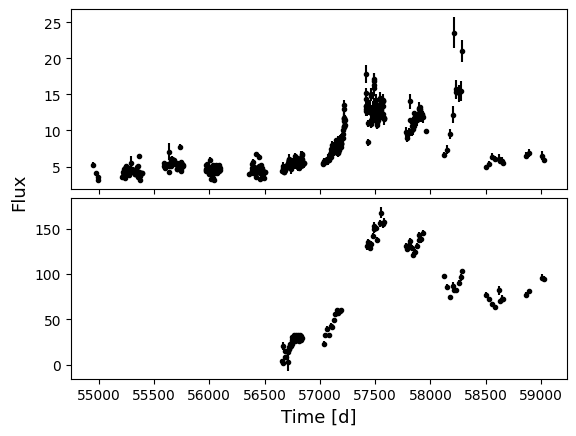

In [1]:
import numpy as np
import matplotlib.pyplot as plt

main_dir = 'pypetal/examples/dat/rm017_'
x1, y1, yerr1 = np.loadtxt(main_dir + 'cont.txt', unpack=True, usecols=[0,1,2])
x2, y2, yerr2 = np.loadtxt( main_dir + 'hb.txt', unpack=True, usecols=[0,1,2,])

fig, ax = plt.subplots( 2, 1, sharex=True )

ax[0].errorbar(x1, y1, yerr1, fmt='.k')
ax[1].errorbar(x2, y2, yerr2, fmt='.k')

ax[1].set_xlabel('Time [d]', fontsize=13)
plt.figtext(.03, .5, 'Flux', rotation=90, va='center', fontsize=13 )

plt.subplots_adjust( hspace=.05 )
plt.show()

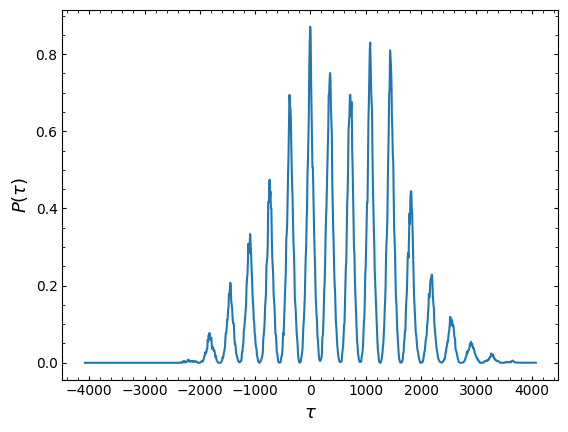

In [3]:
from pypetal.weighting.utils import prob_tau

ptau, ntau, n0, lags = prob_tau(x1, x2, Nlag=1000, gap_size=30, k=2)

plt.plot(lags, ptau)
plt.ylabel(r'$P(\tau)$', fontsize=13)
plt.xlabel(r'$\tau$', fontsize=13)
plt.show()

To augment this weighting scheme, we'll follow <cite data-cite="grier_sloan_2019">Grier et al. (2019)</cite> and convolve $P(\tau)$ with the autocorrelation function (ACF) of the continuum light curve, which gives us the final weight distribution $w(\tau)$.

.. note:: When convolving, we set all points outside of the primary peak in the ACF to 0.

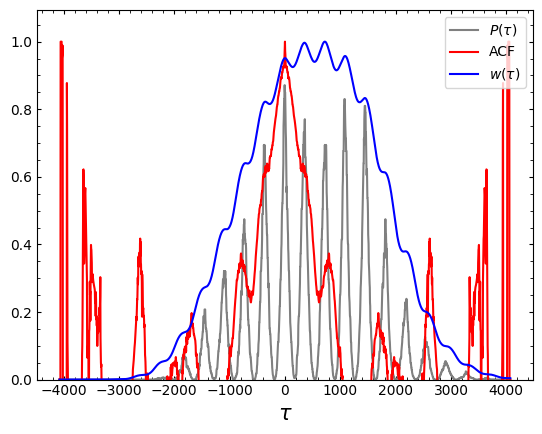

In [4]:
from pypetal.weighting.utils import get_weights

weights, lags, ntau, acf, n0 = get_weights(x1, y1, x2, y2, gap_size=30, k=2)

plt.plot( lags, (ntau/n0)**2, c='gray', label=r'$P(\tau)$' )
plt.plot( lags, acf, c='r', label='ACF' )
plt.plot( lags, weights, c='b', label=r'$w(\tau)$' )

plt.ylim(bottom=0)
plt.xlabel(r'$\tau$', fontsize=15)

plt.legend()
plt.show()

After obtaining the lag distribution, we can then use $w(\tau)$ to find the true peak of the distribution. 

In addition to using the weights, we'll also smooth with a Gaussian distribution after applying the weights. This helps to find peaks in the distribution instead of large spikes in the data. <cite data-cite="grier_sloan_2019">Grier et al. (2019)</cite> use a Gaussian with a width of 15 days, though this can be input by the user.

After isolating the primary peak with the smoothed distribution, we'll downsample the original distribution to only contain samples within the primary peak. We'll then use this dowsnampled distribution to perform all future analysis.

## Weighting in pyPetal

Now, we can use the weight distribution to weight the lag distributions output from pyPetal.

pyPetal can weight output lag distributions from 3 of the modules: the CCCD from pyCCF, the lag distribution from PyROA, and the lag distribution from JAVELIN.

If the weighting module is run, it will detect which module (pyCCF, PyROA, and/or JAVELIN) was used, and weight their output distributions.

Weighting in pyPetal uses the ``pypetal.pipeline.run_weighting`` function. This can be used when any combination of the affected modules are run, and must be done after the ``pypetal`` and/or ``pypetal-jav`` pipelines were run. The main arguments for ``run_weighting`` are:

* ``output_dir``

* ``line_names``

* ``run_pyccf`` - Whether pyCCF was run

* ``pyccf_params`` - The parameters used for the pyCCF run

* ``run_pyroa`` - Whether PyROA was run

* ``pyroa_params`` - The parameters used for the PyROA run

* ``run_javelin`` - Whether JAVELIN was run

* ``javelin_params`` - The parameters used for the JAVELIN run

The weighting module takes the following optional input arguments (to be input under ``weighting_params``):

* ``gap_size``: The minimum gap size to use to detect gaps in the continuum light curve when obtaining $N(\tau)$.

* ``k``: The exponent used when calculating $P(\tau)$

* ``width``: The width of the Gaussian used to smooth the weighted distribution to find the primary peak.

* ``rel_height``: The relative height (0-1) to use for the peak-finding algorithm.

* ``zoom``: Whether tozoom in on the peak with an inset in the output plot.

The general keyword arguments used in ``pypetal.pipeline.run_pipeline`` can be used in ``run_weighting`` as well.

## Using the Weighting Module

We'll perform an example run of the weighting module using the output from the quick-start example:

In [6]:
import pypetal.pipeline as pl

output_dir = 'weighting_output/'
line_names = ['Continuum', 'H-alpha', 'H-beta']

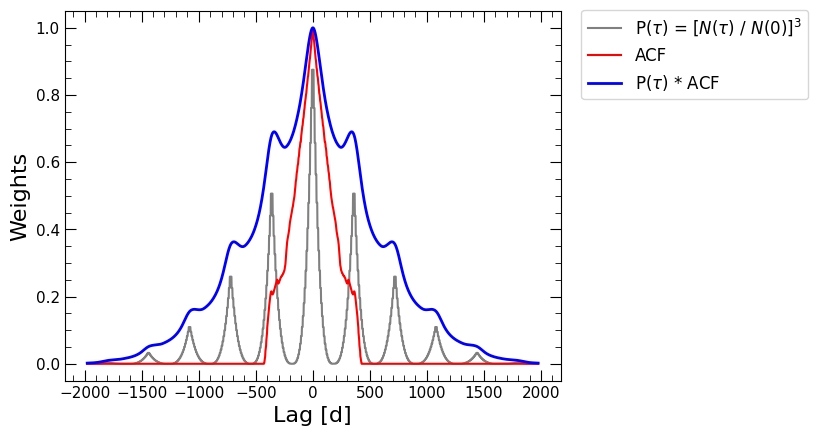

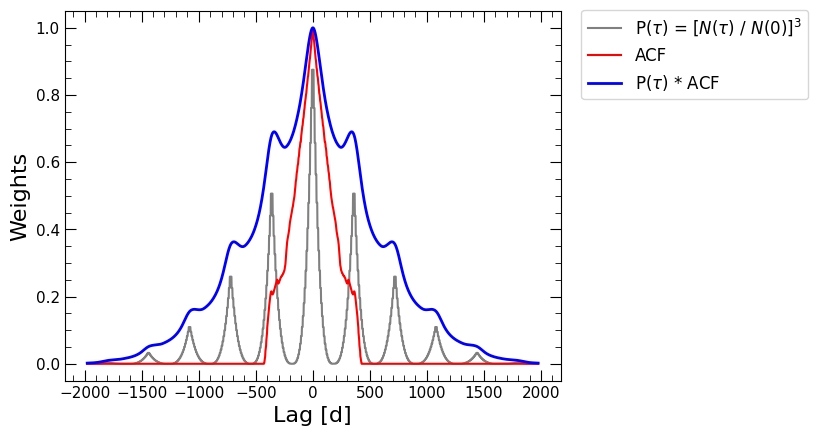

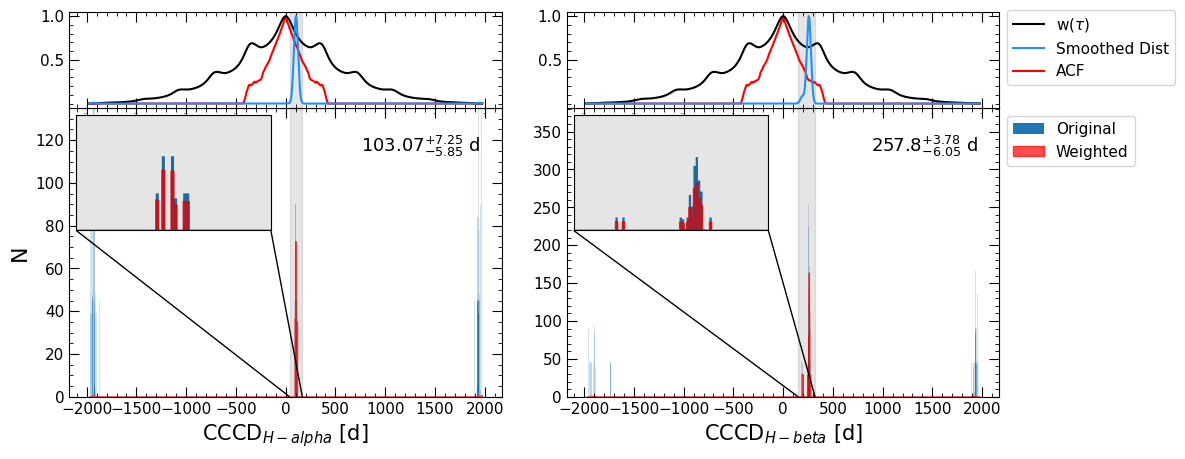

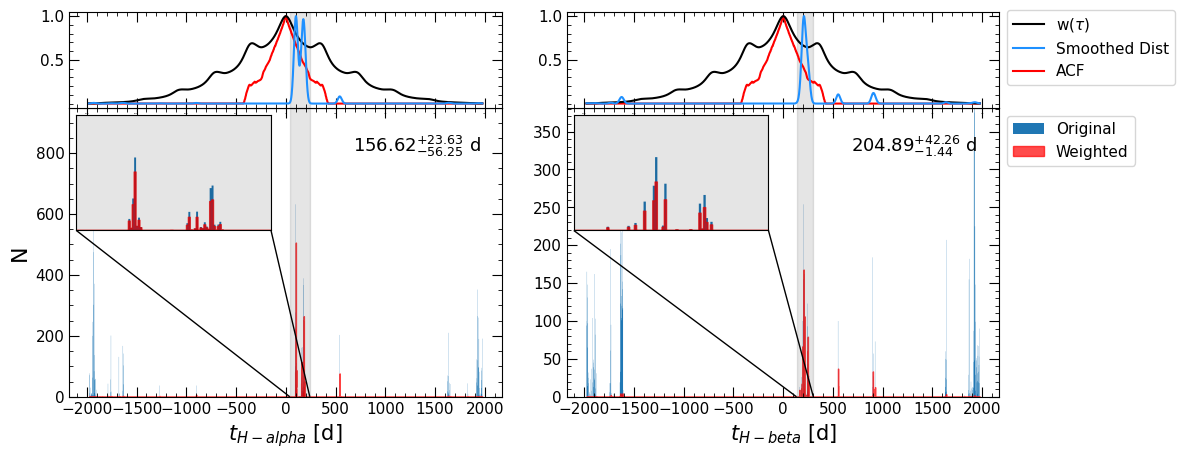

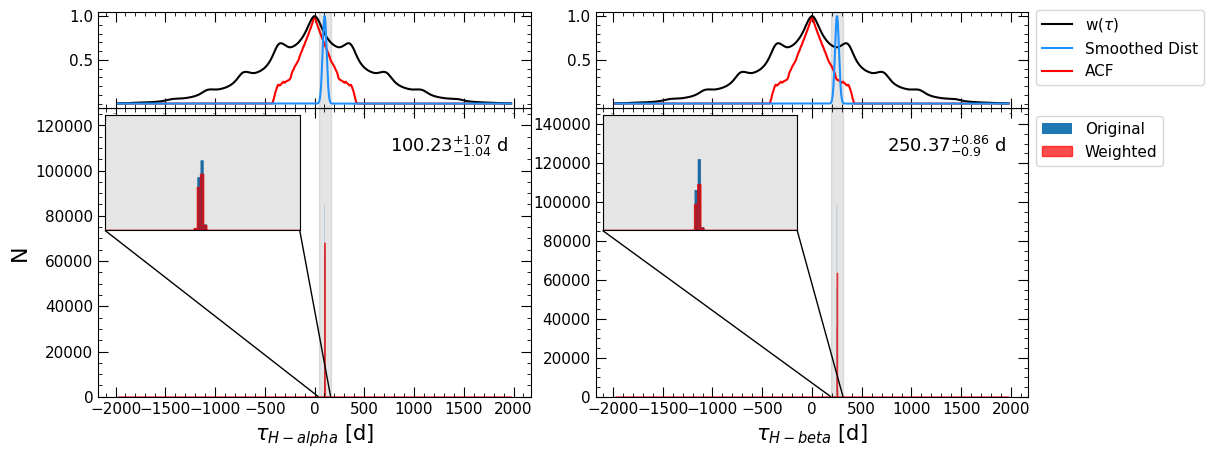

In [7]:
weighting_params = {
    'k': 3,
    'width': 20
}

res, summary = pl.run_weighting( output_dir, line_names,
                                run_pyccf=True, pyccf_params={},
                                run_pyroa=True, pyroa_params={},
                                run_javelin=True, javelin_params={},
                                weighting_params=weighting_params,
                                verbose=True,
                                plot=True,
                                file_fmt='ascii',
                                threads=45)

We can see that pyPetal ouptput a number of plots from the pyCCF, PyROA, and JAVELIN modules that we have seen before, as well as diagnostic plots from the weighting process. 

The first plot is similar to the plot made at the beginning of this notebook, showing $w(\tau)$, $P(\tau)$, and the ACF of the continuum. 

The next three plots show the weighted distributions of the CCCD, the time lag from JAVELIN $t$, and the time lag from PyROA $\tau$. The top panel shows the ACF of the continuum, the weight distribution $w(\tau)$, and the weighted lag distributions that have been smoothed with a Gaussian. The bounds of the detected primary peak are shaded in gray.

The bottom panel shows the original distribution in blue and the weighted distribution (without smoothing) in red. Since ``zoom=True`` in the weighting arguments, an inset is produced in the plot zooming in on the primary peak. 

We can see that the weighting helped identify the actual peak in the CCCD, whereas the original CCCD had false peaks at the edges of the distribution. 

.. note:: If we had only run pyCCF or JAVELIN, there would be only one output plot, for either the CCCD or JAVELIN lag.

## Output Files

The weighting module has a number of outputs, for all of the modules that were run. Each line will have a directory ``weights/`` with a number of outputs from the module:

* ``(module)_weighted_lag_dist.dat``: The downsampled lag distribution.

* ``(module)_weights.dat``: Contains a number of weighting distributions for the module's lag distribution
  
  * $N(\tau)$
  
  * $w(\tau)$
  
  * the ACF of the continuum
  
  * the smoothed $P(\tau)$ ("smooth_dist")
  
  * the smoothed $w(\tau)$ ("smooth_weight_dist") 
  
  * the lags they were computed on

* ``weight_summary.fits``: A text file containing various quantities from both the CCCD, PyROA lag, and JAVELIN lag weighting. Contains the following columns:

  * ``k``: The exponent used to calculate $P(\tau)$

  * ``n0_(module)``: $N(0)$

  * ``peak_bounds_(module)``: The bounds of the primary peak, given as [lower bound, upper bound]

  * ``peak_(module)``: The peak of the primary peak

  * ``lag_(module)``: The median of the downsampled lag distribution

  * ``lag_err_(module)``: The uncertainty on the lag, given as [lower error, upper error]

  * ``frac_rejected``: The fraction of the original distribution that was rejected to obtain the downsampled distribution.

  * ``rmax_(module)``: The maximum value of the CCCD within the region covered by the uncertainty of the lag of the given module.

where ``(module)`` can be "pyccf", "pyroa", or "javelin". 

Each line will also have a figure to show the weighting distribution ($P(\tau)$, the ACF, $w(\tau)$) in the ``weights/`` directory, labeled ``(name)_weights.pdf``.

The main directory ``output_dir`` will also contain one figure for each module (pyCCF, PyROA, and/or JAVELIN), showing the detected lag and the weighted+original distributions (as shown above with the inset plot), labeled ``(module)_weights_res``. These plots will contain subplots for each line.

## Output Dict

All results from the weighting module will be under the ``weighting res`` key of the overall pyPetal output. This will be another dictionary, with one key for each module (``pyccf``, ``pyroa``, and ``javelin``), as well as a key for ``rmax``.


All modules will have the following keys, which are arrays, with values for each line:

* ``bounds``: The bounds and lag value of the primary peak, given as [lower bound, peak, upper bound]

* ``acf``: The ACF of the continuum

* ``lags``: The lags that the weighting distributions are computed on

* ``weight_dist``: The weight distribution $w(\tau)$

* ``smooth_dist``: The smoothed $w(\tau)$

* ``ntau``: The number of overlapping points at a given lag $N(\tau)$

* ``frac_rejected``: The fraction of the original CCCD rejected when downsampling


The ``pyccf`` dictionary will contain the following keys, which are arrays, with values for each line:

* ``centroid``: The median of the downsampled CCCD and its uncertainties, given as [lower error, value, upper error]

* ``downsampled_CCCD``: The downsampled CCCD

The ``pyroa`` dictionary will contain the following keys, which are arrays, with values for each line:

* ``time_delay``: The median of the PyROA lag and its uncertainties, given as [lower error, value, upper error]

* ``downsampled_lag_dist``: The downsampled PyROA lag distribution

The ``javelin`` dictionary will contain the following keys, which are arrays, with values for each line:

* ``tophat_lag``: The median of the JAVELIN lag and its uncertainties, given as [lower error, value, upper error]

* ``downsampled_lag_dist``: The downsampled JAVELIN lag distribution

In [14]:
res['pyccf'].keys()

dict_keys(['centroid', 'bounds', 'acf', 'lags', 'weight_dist', 'smoothed_dist', 'ntau', 'frac_rejected', 'CCCD', 'downsampled_CCCD'])

In [ ]:
res['rmax_pyroa']

## Output Summary Dict

The weighting function ``run_weighting`` will also output a list of the summary dictionaries (one for each line), described above and saved in ``weighting_summary.fits``:

In [13]:
summary[0].keys()

dict_keys(['k', 'n0_pyccf', 'peak_bounds_pyccf', 'peak_pyccf', 'lag_pyccf', 'lag_err_pyccf', 'frac_rejected_pyccf', 'rmax_pyccf', 'n0_javelin', 'peak_bounds_javelin', 'peak_javelin', 'lag_javelin', 'lag_err_javelin', 'frac_rejected_javelin', 'rmax_javelin', 'n0_pyroa', 'peak_bounds_pyroa', 'peak_pyroa', 'lag_pyroa', 'lag_err_pyroa', 'frac_rejected_pyroa', 'rmax_pyroa'])

If a given module is not run, its values in the dictionary will be ``NaN``s.